# Bike Rides and the Poisson Model

To help the urban planners, you are called to model the daily bike rides in NYC using [this dataset](https://gist.github.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/archive/7a5131d3f02575668b3c7e8c146b6a285acd2cd7.zip).  The dataset contains date, day of the week, high and low temp, precipitation and bike ride couunts as columns. 



## Maximum Likelihood I 
 
The obvious choice in distributions is the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) which depends only on one parameter, λ, which is the average number of occurrences per interval. We want to estimate this parameter using Maximum Likelihood Estimation.

Implement a Gradient Descent algorithm from scratch that will estimate the Poisson distribution according to the Maximum Likelihood criterion. Plot the estimated mean vs iterations to showcase convergence towards the true mean. 

References: 

1. [This blog post](https://towardsdatascience.com/the-poisson-process-everything-you-need-to-know-322aa0ab9e9a). 

2. [This blog post](https://towardsdatascience.com/understanding-maximum-likelihood-estimation-fa495a03017a) and note the negative  log likelihood function.  


lambda* from gradient descent :  2680.0420560747625
Log Likelyhood for Lambda* :  3952001.7180423485


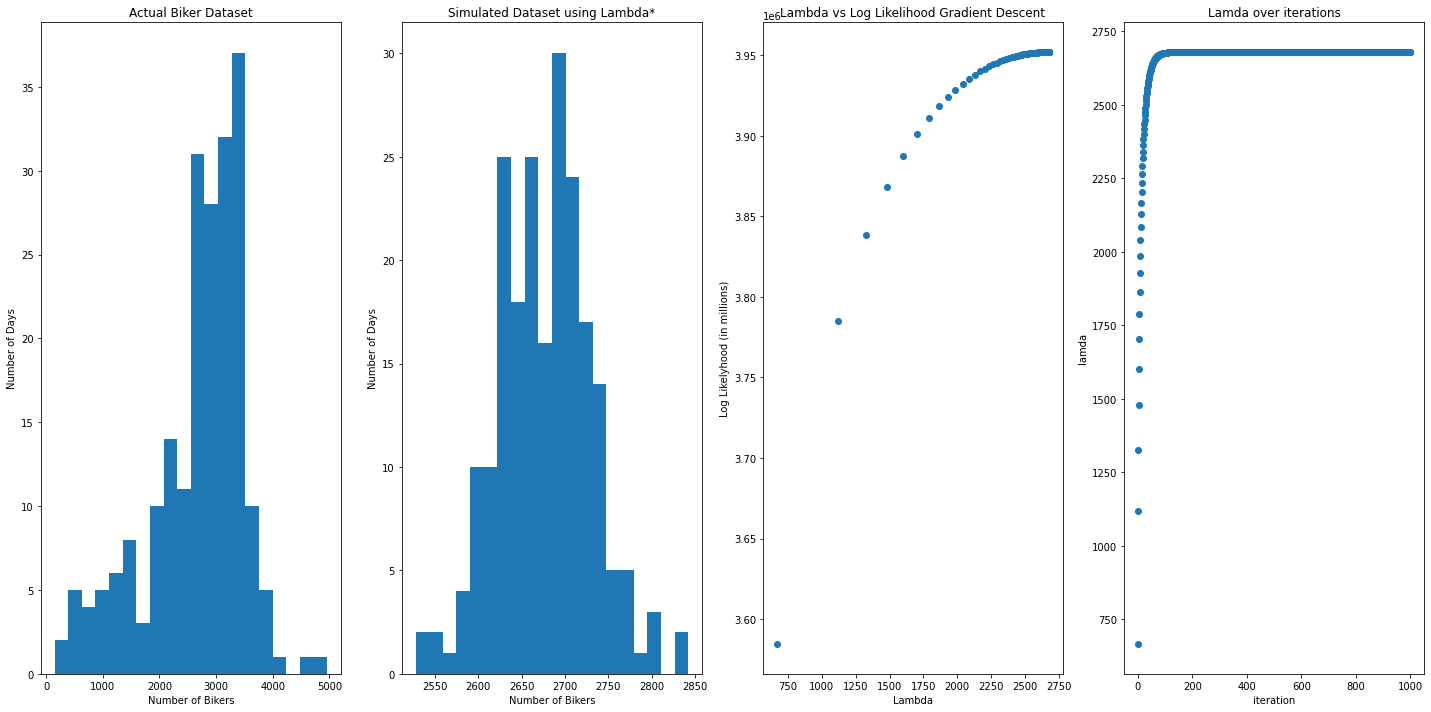

In [285]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import poisson


#estimationg for mu using maximum log likelihood derivation, from reference 2
def getMu(x):
  sigX=0
  n=0
  for i in x:
    sigX+=i
    n+=1
  return sigX/n

#factorial function
def factorial(x):
  sum=0
  for i in range(x):
    sum+=i
  return sum

#calculates log likelihood
def LLK(X, mu):
  llk=0
  for x in X:
    llk+=np.log(mu)*x-mu-np.log((x))
  return llk

#calculates the partial derivitave of the log likelihood function with respect to lambda (LOSS FUNCTION)
def LLK_Gradient(X,mu):
  sum=0;
  n=0
  for x in X:
    sum+=x
    n+=1
  return (1/mu)*sum-n

#iterative method for finding lambda*
def iterative(X):
  llks=[]
  mus=[]
  for i in range(X.min(),X.max(),4):
    llks.append(LLK(X,i))
    mus.append(i)
  return mus,llks

#Gradient descent for finding lambda*
def GradDesc(X,eta,iter):
  iteration=[]
  mu_set=[]
  mu=np.random.randint(X.min(),X.max())
  for i in range(iter):
    iteration.append(i)
    mu_set.append(mu)
    #print(LLK_Gradient(X,mu))
    mu=mu+eta*LLK_Gradient(X,mu)
  return mu, mu_set,iteration




data=pd.read_csv("./nyc_bb_bicyclist_counts.csv")
bb_count=data.loc[:,"BB_COUNT"].values






#print(iterative(bb_count))
lam, lam_set,iteration=GradDesc(bb_count,0.7,1000)
lamLLK_set=[]
for mu in lam_set:
  lamLLK_set.append(LLK(bb_count,mu))

simulated=[]
for i in range(len(bb_count)):
  simulated.append(np.random.poisson(lam))

mu_set, muLLK_set=iterative(bb_count)

print("lambda* from gradient descent : ",lam)
print("Log Likelyhood for Lambda* : ",(LLK(bb_count,getMu(bb_count))))

fig, axis= plt.subplots(1, 4, figsize=(20, 10))

axis[0].hist(bb_count,20)
axis[0].set_title("Actual Biker Dataset")
axis[0].set_xlabel("Number of Bikers")
axis[0].set_ylabel("Number of Days")

axis[1].hist(simulated,20)
axis[1].set_title("Simulated Dataset using Lambda*")
axis[1].set_xlabel("Number of Bikers")
axis[1].set_ylabel("Number of Days")

axis[2].scatter(lam_set,lamLLK_set)
axis[2].set_title("Lambda vs Log Likelihood Gradient Descent")
axis[2].set_xlabel("Lambda")
axis[2].set_ylabel("Log Likelyhood (in millions)")

axis[3].scatter(iteration,lam_set)
axis[3].set_title("Lamda over iterations")
axis[3].set_xlabel("iteration")
axis[3].set_ylabel("lamda")

fig.tight_layout()


 
plt.show()



The first figure on the left is a histogram of the provided dataset. The second fingure, second from left, shows a simulated dataset using 𝝺* calculated from the gradient descent, and numpy.random.poisson(). The second figure has less outliers, and forms a more uniform distrobution, but maintains a similar shape to the acutal dataset. 

The 3rd figure, second from the right, is a scatter plot showing the different log-likelihoods for all lambdas genorated during the gradient descent. The first lambda used is the lowest point on the graph, and all subsequent points move towards the true mean, 𝝺*, and gradually increase in log likelihood. The final point with the highest log likelihood is close to 𝝺*, with approximatly the maximum log likelihood.
 The rightmost figure is another scatterplot which shows the progression of lamda over the iterations of the gradient descent. The values for lamda converger quickly to the approximate value of 𝝺*.

## Maximum Likelihood II

A colleague of yours suggest that the parameter $\lambda$ must be itself dependent on the weather and other factors since people bike when its not raining. Assume that you model $\lambda$ as 

$$\lambda_i = \exp(\mathbf w^T \mathbf x_i)$$

where $\mathbf x_i$ is one of the example features and $\mathbf w$ is a set of parameters. 

Train the model with SGD with this assumption and compare the MSE of the predictions with the `Maximum Likelihood I` approach. 

You may want to use [this partial derivative of the log likelihood function](http://home.cc.umanitoba.ca/~godwinrt/7010/poissonregression.pdf)

In [422]:
from numpy.core.multiarray import dot
data=pd.read_csv("./nyc_bb_bicyclist_counts.csv")
y=data.loc[:,"BB_COUNT"].values
precip=data.loc[:,"PRECIP"].values
high=data.loc[:,"HIGH_T"].values
low=data.loc[:,"LOW_T"].values
m=len(y)

n_epochs=500
np.random.seed(42)

def makeX(precip,high,low,size):
  X=[]
  for i in range(size):
    X.append([precip[i],high[i]/100,low[i]/100])
  return np.array(X)


X=makeX(precip,high,low,m)

w=[1,1,1]

#def getGrads(X,y,w,m):
#  gradients=[0]
#  for i in range(m):
#    gradients=gradients+(y[i]-np.exp(w @ X[i].T))*X[i]
#  return gradients

for epoch in range(n_epochs):
  for iteration in range(m):
    random_index=np.random.randint(m)
    xi=X[random_index:random_index+1]
    yi=y[random_index:random_index+1]
    #print(yi,xi,w, "yi-xi-w")
    #print(np.dot(w,xi.T),"wTx")
    #print(np.exp(np.dot(w,xi.T)), "yhat")
    gradients=(yi-np.exp(np.dot(w,xi.T)))*xi
    #gradients=getGrads(X,y,w,m)
    #print(gradients,"gradient")
    eta=8*10**-5
    w=w+eta*gradients
    #print(w,"new w")

#print(w)

lamdas=[]
for i in range(m):
  lamdas.append(np.exp(np.dot(w,X[i])))
  #print(lamdas[i][0],y[i])



MSELLK1 = 0
MSELLK2 = 0
for i in range(m):
  MSELLK1+=(lam_set[i]-y[i])**2
  MSELLK2+=(lamdas[i][0]-y[i])**2
MSELLK1=MSELLK1/m
MSELLK2=MSELLK2/m

print("Mean squared error for method 1: ",MSELLK1)
print("Mean squared error for method 2: ",MSELLK2)

Mean squared error for method 1:  692017.6584942794
Mean squared error for method 2:  3000035.1120429407


The mean squared error is much lower in the first method than the second one. Furthermore, the mean squared error is noticable very high in lambda set using the second method. This could be indicitave of a flaw in the GDS algorithm which optimizes our parameter set, w. It could also indicated that the weather has very little effect on the number of cyclists crossing the bridge. I beleive that the former is the case, and specifically that the gradient function is not working correctly. 